## Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm.auto import tqdm, trange
import re
import torch
from torch import nn
import torch.nn.functional as F
from collections import defaultdict
from utils import load_imdb
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
device = 'cuda'
model = AutoModelForCausalLM.from_pretrained('gpt2-medium').to(device)
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")

In [3]:
emb = model.get_output_embeddings().weight.data.T
num_layers = model.config.n_layer
num_heads = model.config.n_head
hidden_dim = model.config.n_ctx
head_size = hidden_dim // num_heads

K = torch.cat([model.get_parameter(f"transformer.h.{j}.mlp.c_fc.weight").T
                           for j in range(num_layers)]).detach()
V = torch.cat([model.get_parameter(f"transformer.h.{j}.mlp.c_proj.weight")
                           for j in range(num_layers)]).detach()
W_Q, W_K, W_V = torch.cat([model.get_parameter(f"transformer.h.{j}.attn.c_attn.weight") 
                           for j in range(num_layers)]).detach().chunk(3, dim=-1)
W_O = torch.cat([model.get_parameter(f"transformer.h.{j}.attn.c_proj.weight") 
                           for j in range(num_layers)]).detach()

K_heads = K.reshape(num_layers, -1, hidden_dim)
V_heads = V.reshape(num_layers, -1, hidden_dim)
d_int = K_heads.shape[1]

W_V_heads = W_V.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_O_heads = W_O.reshape(num_layers, num_heads, head_size, hidden_dim)
W_Q_heads = W_Q.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_K_heads = W_K.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)

In [5]:
sents = load_imdb()
sents = [s for s in sents if len(s) > 100]

Reusing dataset imdb (/home/guydar/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
E1 = emb

In [29]:
ln_f = model.transformer.ln_f.cpu()
emb = emb.cpu()
emb_func = lambda x: ln_f(x) @ emb

### Memorize Intermediate States

In [7]:
mem = defaultdict(list)
def _memorize_inp_outp(sm, only_last=None):
    global tokenizer
    def f(m, inp, outp):
        inp = inp[0]
        outp = outp[0]
        if only_last:
            inp, outp = inp[-only_last:], outp[-only_last:]
        inp, outp = (inp.squeeze(), outp.squeeze())

        if 'attn.c_proj' in sm:
            mem[f"intermediate-{sm}"].append((inp.cpu().detach(), outp.cpu().detach()))
            inp = inp.reshape(inp.shape[0], num_heads, head_size)
            layer_idx = int(re.search(r'\.h\.(\d+)\.', sm).group(1))
            inp_ = torch.empty(inp.shape[0], inp.shape[1], hidden_dim)
            for head_idx in range(inp.shape[1]):
                inp_[:, head_idx] = (inp[:, head_idx].unsqueeze(1) @ W_O_heads[layer_idx][head_idx]).squeeze()
            inp = inp_
        mem[sm].append((inp.cpu().detach(), outp.cpu().detach()))
    return f
    
submodules = [
              *[f'transformer.h.{j}.attn' for j in range(num_layers)],
              *[f'transformer.h.{j}.attn.c_proj' for j in range(num_layers)],
              *[f'transformer.h.{j}' for j in range(num_layers)],
              *[f'transformer.h.{j}.mlp.c_fc' for j in range(num_layers)],
            ]
if 'mem_hooks' in globals():
    [h.remove() for h in mem_hooks]
mem_hooks = []
for sm in submodules:
    mem_hooks.append(model.get_submodule(sm).register_forward_hook(_memorize_inp_outp(sm)))

In [8]:
sent_stop = 1024
num_sent_samples = 60
sents_sample = np.random.choice(sents, size=num_sent_samples)

In [9]:
for i in trange(num_sent_samples):
    sampled_sent = sents_sample[i] # sents[i] #
    sampled_sent = ' '.join(sampled_sent.split(' ')[:sent_stop])
    model(**{k: v.to(device) if isinstance(v, torch.Tensor) else v
                      for k, v in tokenizer(sampled_sent, return_tensors='pt', truncation=True).items()})

  0%|          | 0/60 [00:00<?, ?it/s]

## Experiments

In [10]:
only_ascii = False
k_ = 100
max_explored_tokens = 1000

### Hidden States and Parameters

In [20]:
def _batched_recall_metric(xs, y, k=100, k2=None, only_ascii=False):
    if k2 is None:
        k2 = k
    out = []
    xs_idx = torch.topk(xs, k=k, dim=-1).indices
    y_idx = torch.topk(y, k=k2, dim=-1).indices
    for i in range(len(y)):
        A = set(xs_idx[i].ravel().cpu().tolist())
        B = set(y_idx[i].cpu().tolist())
        if only_ascii:
            A, B = map(lambda X: {x for x in X if tokenizer.decode(x).isascii()}, (A, B))
        out.append(len(A & B) / len(B))
    return out        

In [30]:
real_K_recall, fake_K_recall, real_V_recall, fake_V_recall = [], [], [], []

for i1 in trange(num_layers):
    sum_lens = sum([len(x[0]) for x in mem[f'transformer.h.0.mlp.c_fc']])
    tmp1_pre = torch.topk(torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[:max_explored_tokens], 
                          k=5, dim=-1).indices
    tmp1_pre_perm = torch.topk(
        torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[torch.randperm(sum_lens)[:max_explored_tokens]], 
                               k=5, dim=-1).indices
    tmp1_K, tmp1_V = K_heads[i1][tmp1_pre] @ E1, V_heads[i1][tmp1_pre] @ E1
    tmp1_K_perm, tmp1_V_perm = K_heads[i1][tmp1_pre_perm] @ E1, V_heads[i1][tmp1_pre_perm] @ E1
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{i1}']])[:max_explored_tokens])

    fake_K_recall.append(np.mean(_batched_recall_metric(tmp1_K_perm, tmp2, k=k_, only_ascii=only_ascii)))
    real_K_recall.append(np.mean(_batched_recall_metric(tmp1_K, tmp2, k=k_, only_ascii=only_ascii)))
    fake_V_recall.append(np.mean(_batched_recall_metric(tmp1_V_perm, tmp2, k=k_, only_ascii=only_ascii)))
    real_V_recall.append(np.mean(_batched_recall_metric(tmp1_V, tmp2, k=k_, only_ascii=only_ascii)))

  0%|          | 0/24 [00:00<?, ?it/s]

In [32]:
real_WV_recall, fake_WV_recall, real_WO_recall, fake_WO_recall = [], [], [], []

for i1 in trange(num_layers):
    tmp1_pre = torch.topk(torch.cat([x for x, _ in mem[f'intermediate-transformer.h.{i1}.attn.c_proj']])[:max_explored_tokens], k=5, dim=-1).indices
    tmp1_x, tmp1_y = np.unravel_index(tmp1_pre.numpy(), (num_heads, head_size))
    del tmp1_pre
    tmp1_WV, tmp1_WO = W_V_heads[i1, tmp1_x, :, tmp1_y] @ E1, W_O_heads[i1, tmp1_x, tmp1_y] @ E1
    tmp1 = tmp1_WV
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{i1}']])[:max_explored_tokens])
    fake_WV_recall.append(np.mean(_batched_recall_metric(tmp1_WV[torch.randperm(len(tmp1_WV))], tmp2)))
    real_WV_recall.append(np.mean(_batched_recall_metric(tmp1_WV, tmp2)))
    fake_WO_recall.append(np.mean(_batched_recall_metric(tmp1_WO[torch.randperm(len(tmp1_WO))], tmp2)))
    real_WO_recall.append(np.mean(_batched_recall_metric(tmp1_WO, tmp2)))

  0%|          | 0/24 [00:00<?, ?it/s]

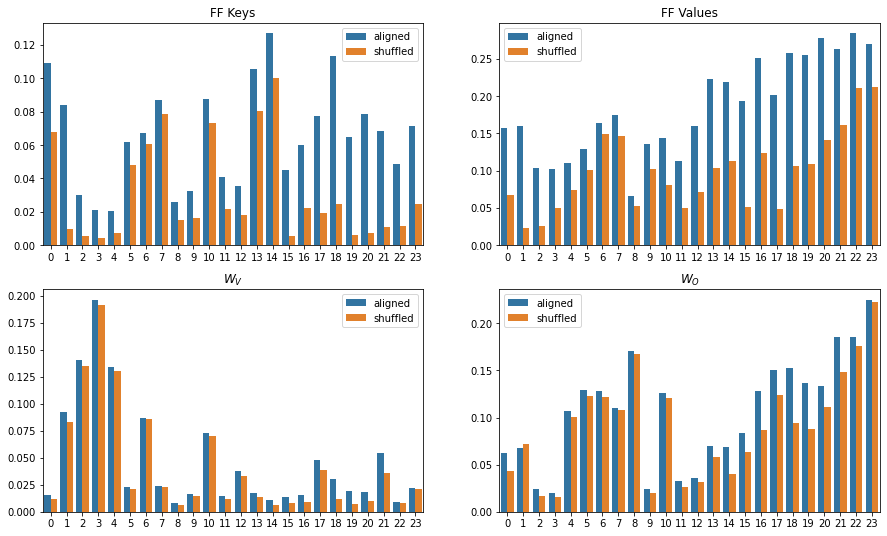

In [35]:
plt.figure(figsize=(15, 9))
for i, (real, fake, param_name) in enumerate([(real_K_recall, fake_K_recall, "FF Keys"),
                                              (real_V_recall, fake_V_recall, "FF Values"),
                                              (real_WV_recall, fake_WV_recall, "$W_V$"),
                                              (real_WO_recall, fake_WO_recall, "$W_O$")
                                             ]):
    plt.subplot(2, 2, i + 1)
    plt.title(param_name)
    sns.barplot(x='x', y='y', hue='hue',
                data={'x': [*np.arange(num_layers), *np.arange(num_layers)],
                      'y': [*real, *fake],
                      'hue': (['aligned'] * num_layers) + (['shuffled'] * num_layers)
                })

### Related Parameter Pairs are Connected

In [38]:
def _batched_sim(x, y, k=100):
    out = []
    x_idx = torch.topk(x, k=k, dim=-1).indices
    y_idx = torch.topk(y, k=k, dim=-1).indices
    for i in range(len(y)):
        A, B = set(x_idx[i].cpu().tolist()), set(y_idx[i].cpu().tolist())
        out.append(len(A & B) / len(A | B))
    return out

In [41]:
intersections_dict = {}

In [42]:
intersections_dict['KV'] = np.array([_batched_sim(abs(K_heads[l] @ E1), abs(V_heads[l] @ E1)) for l in trange(num_layers)])

  0%|          | 0/24 [00:00<?, ?it/s]

In [43]:
intersections_dict['KV_shuffled'] = np.array([_batched_sim(abs(K_heads[l][torch.randperm(K_heads.shape[1])] @ E1), 
                                                            abs(V_heads[l] @ E1)) for l in trange(num_layers)])

  0%|          | 0/24 [00:00<?, ?it/s]

In [46]:
intersections_dict['W_VO'] = np.array([_batched_sim(abs(W_V_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1), 
                                                                  abs(W_O_heads[l].flatten(0, 1) @ E1)) 
                                           for l in trange(num_layers)])

  0%|          | 0/24 [00:00<?, ?it/s]

In [47]:
intersections_dict['W_VO_shuffled'] = np.array([_batched_sim(abs(W_V_heads[l].permute(0, 2, 1).flatten(0, 1) @ E1), 
                                                                  abs(W_O_heads[l].flatten(0, 1)[torch.randperm(W_O_heads.size(-1))] @ E1)) 
                                                    for l in trange(num_layers)])

  0%|          | 0/24 [00:00<?, ?it/s]

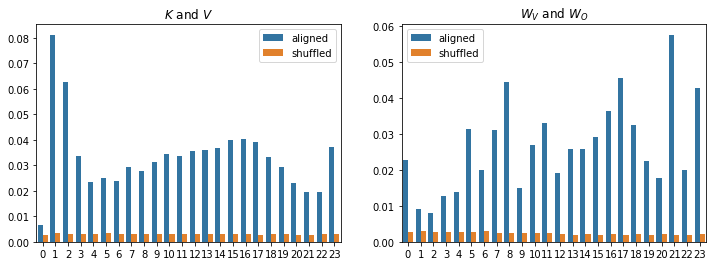

In [51]:
plt.figure(figsize=(12, 4))
for i, (title, dict_key) in enumerate([('$K$ and $V$', 'KV'),
                                      ('$W_V$ and $W_O$', 'W_VO'),
                                      ]):
    plt.subplot(1, 2, i+1)
    plt.title(title)
    sns.barplot(x='x', y='y', hue='hue', 
                data={'x': [*np.arange(num_layers), *np.arange(num_layers)],
                      'y': [*np.mean(intersections_dict[dict_key], axis=-1), 
                            *np.mean(intersections_dict[f'{dict_key}_shuffled'], axis=-1)],
                      'hue': (['aligned'] * num_layers) + (['shuffled'] * num_layers)
                });

### Model Logits and Parameters

In [66]:
real_K_recall2, fake_K_recall2, real_V_recall2, fake_V_recall2 = [], [], [], []

for i1 in trange(num_layers):
    sum_lens = sum([len(x[0]) for x in mem[f'transformer.h.0.mlp.c_fc']])
    tmp1_pre = torch.topk(torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[:max_explored_tokens], 
                          k=5, dim=-1).indices
    tmp1_pre_perm = torch.topk(
        torch.cat([y for _, y in mem[f'transformer.h.{i1}.mlp.c_fc']])[torch.randperm(sum_lens)[:max_explored_tokens]], 
                               k=5, dim=-1).indices
    tmp1_K, tmp1_V = K_heads[i1][tmp1_pre] @ E1, V_heads[i1][tmp1_pre] @ E1
    tmp1_K_perm, tmp1_V_perm = K_heads[i1][tmp1_pre_perm] @ E1, V_heads[i1][tmp1_pre_perm] @ E1
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{num_layers-1}']])[:max_explored_tokens])

    fake_K_recall2.append(np.mean(_batched_recall_metric(tmp1_K_perm, tmp2, k=k_, only_ascii=only_ascii)))
    real_K_recall2.append(np.mean(_batched_recall_metric(tmp1_K, tmp2, k=k_, only_ascii=only_ascii)))
    fake_V_recall2.append(np.mean(_batched_recall_metric(tmp1_V_perm, tmp2, k=k_, only_ascii=only_ascii)))
    real_V_recall2.append(np.mean(_batched_recall_metric(tmp1_V, tmp2, k=k_, only_ascii=only_ascii)))

  0%|          | 0/24 [00:00<?, ?it/s]

In [65]:
real_WV_recall2, fake_WV_recall2, real_WO_recall2, fake_WO_recall2 = [], [], [], []

for i1 in trange(num_layers):
    tmp1_pre = torch.topk(torch.cat([x for x, _ in mem[f'intermediate-transformer.h.{i1}.attn.c_proj']])[:max_explored_tokens], k=5, dim=-1).indices
    tmp1_x, tmp1_y = np.unravel_index(tmp1_pre.numpy(), (num_heads, head_size))
    del tmp1_pre
    tmp1_WV, tmp1_WO = W_V_heads[i1, tmp1_x, :, tmp1_y] @ E1, W_O_heads[i1, tmp1_x, tmp1_y] @ E1
    tmp1 = tmp1_WV
    tmp2 = emb_func(torch.cat([y for _, y in mem[f'transformer.h.{num_layers-1}']])[:max_explored_tokens])
    fake_WV_recall2.append(np.mean(_batched_recall_metric(tmp1_WV[torch.randperm(len(tmp1_WV))], tmp2)))
    real_WV_recall2.append(np.mean(_batched_recall_metric(tmp1_WV, tmp2)))
    fake_WO_recall2.append(np.mean(_batched_recall_metric(tmp1_WO[torch.randperm(len(tmp1_WO))], tmp2)))
    real_WO_recall2.append(np.mean(_batched_recall_metric(tmp1_WO, tmp2)))

  0%|          | 0/24 [00:00<?, ?it/s]

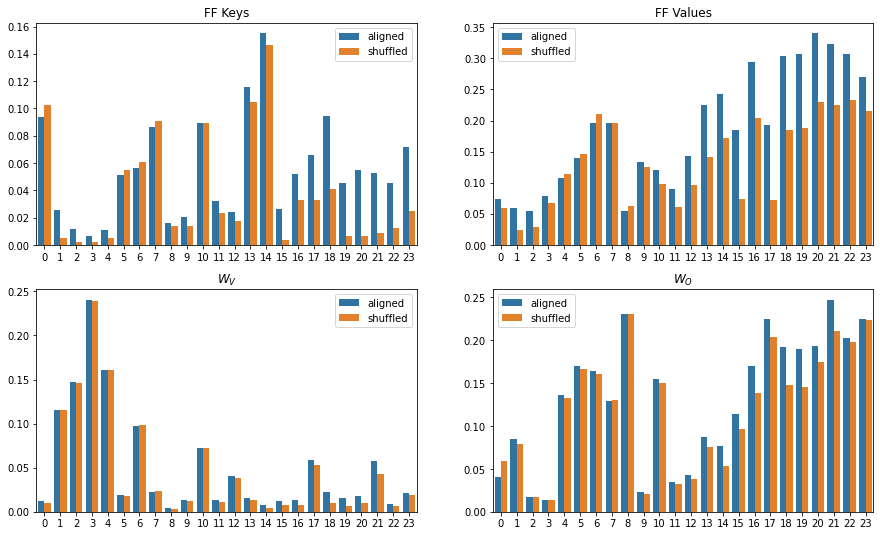

In [67]:
plt.figure(figsize=(15, 9))
for i, (real, fake, param_name) in enumerate([(real_K_recall2, fake_K_recall2, "FF Keys"),
                                              (real_V_recall2, fake_V_recall2, "FF Values"),
                                              (real_WV_recall2, fake_WV_recall2, "$W_V$"),
                                              (real_WO_recall2, fake_WO_recall2, "$W_O$")
                                             ]):
    plt.subplot(2, 2, i + 1)
    plt.title(param_name)
    sns.barplot(x='x', y='y', hue='hue',
                data={'x': [*np.arange(num_layers), *np.arange(num_layers)],
                      'y': [*real, *fake],
                      'hue': (['aligned'] * num_layers) + (['shuffled'] * num_layers)
                })